# LVK O4 sumary

In [76]:
import EPTools
import sys
sys.path.append('/Users/liangrunduo/EP/Tools/')
from astropy.cosmology import Planck18
from astropy.coordinates import SkyCoord
from EPTools.utils import *
import numpy as np
import matplotlib.pyplot as plt
from ligo.skymap.io.fits import read_sky_map, write_sky_map
import ligo.skymap.postprocess as postprocess
from astropy.io.fits import writeto
from toolkit import *
import subprocess
save_dir = '/Users/liangrunduo/EP/GW/'
client = GraceDb()

## Download All Superevent Skymaps in O4

In [2]:
O4_messages = retrive_gracedb(query='is_public: True runid: O4 far < 3.17e-8 ')  #We retrieve data with FAR < 1 per yr
print(O4_messages['S241102br'])

{'alert_type': 'UPDATE', 'time_created': '2024-11-03T20:04:48Z', 'superevent_id': 'S241102br', 'urls': {'gracedb': 'https://gracedb.ligo.org/superevents/S241102br/view/'}, 'event': {'significant': True, 'time': '2024-11-02T12:40:58.788Z', 'far': 1.14177774199959e-41, 'instruments': ['H1', 'L1', 'V1'], 'group': 'CBC', 'pipeline': 'gstlal', 'search': 'AllSky', 'properties': {'HasNS': 0.0, 'HasRemnant': 0.0, 'HasMassGap': 0.0002537427048972342}, 'classification': {'BBH': 0.9921335082053966, 'BNS': 3.5277724299018267e-94, 'NSBH': 0.007866491794603327, 'Terrestrial': 1.1102230246251565e-16}, 'duration': None, 'central_frequency': None, 'skymap': 'U0lNUExFICA9ICAgICAgICAgICAgICAgICAgICBUIC8gY29uZm9ybXMgdG8gRklUUyBzdGFuZGFyZCAgICAgICAgICAgICAgICAgICAgICBCSVRQSVggID0gICAgICAgICAgICAgICAgICAgIDggLyBhcnJheSBkYXRhIHR5cGUgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIE5BWElTICAgPSAgICAgICAgICAgICAgICAgICAgMCAvIG51bWJlciBvZiBhcnJheSBkaW1lbnNpb25zICAgICAgICAgICAgICAgICAgICAgRVhURU5EICA9ICAgICAgICAgICAgIC

In [5]:
print(O4_messages['S241102br']['event']['classification'])

{'BBH': 0.9921335082053966, 'BNS': 3.5277724299018267e-94, 'NSBH': 0.007866491794603327, 'Terrestrial': 1.1102230246251565e-16}


In [4]:
'''If you want to get A90 and distance information, 
you should download skymap for each event and process it. 
There is a load_skymap() in my toolkit in R930'''
save_dir = '/Users/liangrunduo/EP/GW/'
client = GraceDb()
for event_id in O4_messages:
    try:
        filename = 'Bilby.offline0.multiorder.fits'
        r = client.files(event_id,'Bilby.offline0.multiorder.fits')
    except:
        try:
            filename = 'Bilby.multiorder.fits'
            r = client.files(event_id,'Bilby.multiorder.fits')
        except:
            try:
                filename = 'bayestar.multiorder.fits'
                r = client.files(event_id,'bayestar.multiorder.fits')
            except:
                print('Retraction: {}'.format(event_id))
                continue
            
    command = ['wget','-O',save_dir+event_id+'_skymap.fits',
               'https://gracedb.ligo.org/api/superevents/{}/files/{}'.format(event_id,filename)]
    output = subprocess.run(command,capture_output=True,text=True)
                

CompletedProcess(args=['wget', '-O', '/Users/liangrunduo/EP/GW/S241102cy_skymap.fits', 'https://gracedb.ligo.org/api/superevents/S241102cy/files/Bilby.offline0.multiorder.fits'], returncode=0, stdout='', stderr='--2024-11-06 11:38:04--  https://gracedb.ligo.org/api/superevents/S241102cy/files/Bilby.offline0.multiorder.fits\n正在解析主机 gracedb.ligo.org (gracedb.ligo.org)... 100.21.214.239, 52.25.57.90, 44.225.177.158\n正在连接 gracedb.ligo.org (gracedb.ligo.org)|100.21.214.239|:443... 已连接。\n已发出 HTTP 请求，正在等待回应... 200 OK\n长度：869760 (849K) [image/fits]\n正在保存至: “/Users/liangrunduo/EP/GW/S241102cy_skymap.fits”\n\n     0K .......... .......... .......... .......... ..........  5%  239K 3s\n    50K .......... .......... .......... .......... .......... 11%  239K 3s\n   100K .......... .......... .......... .......... .......... 17%  121M 2s\n   150K .......... .......... .......... .......... .......... 23%  240K 2s\n   200K .......... .......... .......... .......... .......... 29%  130M 2s\n   250K 

## Process Skymaps

In [2]:
import os
process_area = True
file_list = os.listdir(save_dir)
skymap_data = {}
for filename in file_list:
    indi = filename.split('_')
    event_id = indi[0]
    try:
        skymap, meta = read_sky_map(save_dir+filename,nest=False,distances=True)
        prob = skymap[0]
        if meta['distmean'] < 500:
            skymap_data[event_id] = dict()
            #skymap_data[event_id]['skymap'] = skymap
            skymap_data[event_id]['distmean'] = meta['distmean']
            skymap_data[event_id]['diststd'] = meta['diststd']

            if process_area:
                ra, dec, a, b, pa, area = postprocess.find_ellipse(prob)
                print(event_id+' Dist = {},  A90 = {}'.format(meta['distmean'],area))
                skymap_data[event_id]['A90'] = area
    except:
        print(filename)
        

S230529ay Dist = 197.180803380434,  A90 = 39500.51957692001
.DS_Store
S240925n Dist = 322.535141854722,  A90 = 8443.787087306931
S230814ah Dist = 329.5829480845621,  A90 = 39214.914053559885


/opt/anaconda3/lib/python3.12/site-packages/ligo/skymap/extern/numpy/quantile.py:253: RuntimeWarning: overflow encountered in divide
  ws_sorted[nonzero_w_inds] / ws_sorted[nonzero_w_inds].min()


S241102br Dist = 364.0146333412772,  A90 = 28.84723682092313
S240429an Dist = 13.662503404808366,  A90 = 24836.964756067406


/opt/anaconda3/lib/python3.12/site-packages/ligo/skymap/extern/numpy/quantile.py:253: RuntimeWarning: overflow encountered in divide
  ws_sorted[nonzero_w_inds] / ws_sorted[nonzero_w_inds].min()


S230627c Dist = 290.9508721767887,  A90 = 213.28871790300644


/opt/anaconda3/lib/python3.12/site-packages/ligo/skymap/extern/numpy/quantile.py:253: RuntimeWarning: overflow encountered in divide
  ws_sorted[nonzero_w_inds] / ws_sorted[nonzero_w_inds].min()


S240422ed Dist = 188.18928254533978,  A90 = 271.6338681732656


/opt/anaconda3/lib/python3.12/site-packages/ligo/skymap/extern/numpy/quantile.py:253: RuntimeWarning: overflow encountered in divide
  ws_sorted[nonzero_w_inds] / ws_sorted[nonzero_w_inds].min()


S241011k Dist = 212.20409963130336,  A90 = 115.1641065024183
S230810af Dist = 100.4032777442462,  A90 = 37324.56649824732
S230830b Dist = 214.0960402190468,  A90 = 993.0818538896193


In [ ]:
import glob
os.chdir(save_dir)
result = glob.glob('*.{}'.format('fits'))

10


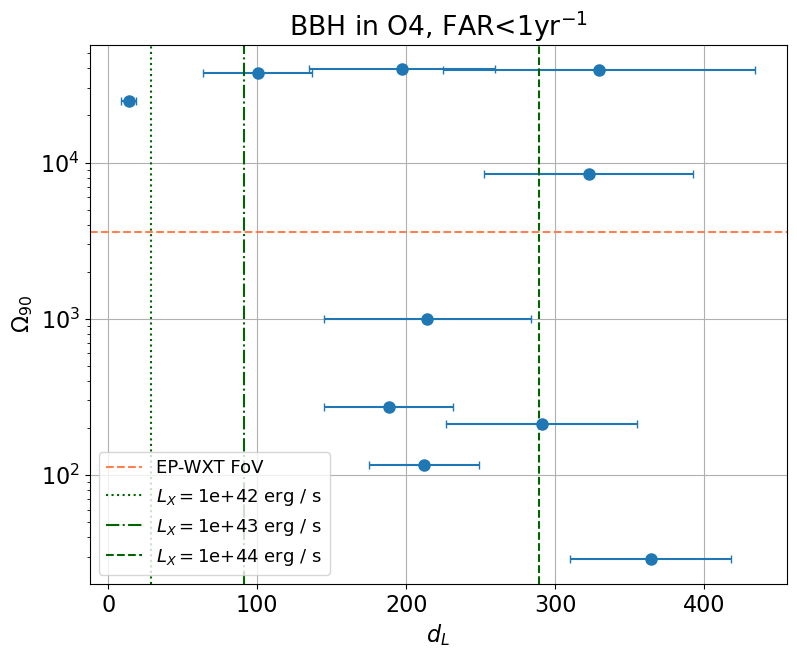

In [65]:
flare_lums = [1e42,1e43,1e44]*u.erg/u.s
flare_flx = 1e-11*u.erg/u.s/(u.cm)**2
flare_dist =np.sqrt(flare_lums/(4*pi*flare_flx)).to(u.Mpc)
lss = [':','-.','--']

plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(figsize=(9,7),dpi=100)
dist_list = np.array([skymap_data[item]['distmean'] for item in skymap_data.keys()])
disterr_list = np.array([skymap_data[item]['diststd'] for item in skymap_data.keys()])
A90_list = np.array([skymap_data[item]['A90'] for item in skymap_data.keys()])
label_list = list(skymap_data.keys())
ax.errorbar(x=dist_list,y=A90_list,xerr=disterr_list,fmt='o',markersize=8,capsize=3)
ax.axhline(y=3600,xmin=0,xmax=500,color='coral',ls='--',label='EP-WXT FoV')
for i,flare_dist_i in enumerate(flare_dist): 
    ax.axvline(x=flare_dist_i.value,ymin=0,ymax=1e4,color='darkgreen',ls=lss[i],
               label='$L_{X} = $'+'{:.0e}'.format(flare_lums[i]))
ax.grid()
ax.set_yscale('log')
ax.set_ylabel(r'$\Omega_{90}$')
ax.set_xlabel(r'$d_{L}$')
ax.legend(fontsize=13)
ax.set_title('BBH in O4, FAR<'+r'$1 \mathrm{yr}^{-1}$')
print(len(list(skymap_data.keys())))
plt.savefig('/Users/liangrunduo/EP/Results/BBH_O4_summary.pdf',dpi=300)